In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
file = None
with open("starlinks_5_2.txt", 'r') as f:
    file = f.readlines()


In [3]:
i = 0
inclination_list = []
ascension_list = []
with open('./starlinks_5_2_brief.txt', 'w') as f:
    while i < len(file):
        name = file[i].strip()
        line_two = file[i + 2].strip()
        inclination = float(line_two[9:16])
        ascension = float(line_two[17:25])
        inclination_list.append(round(inclination))
        ascension_list.append(round(ascension, -1))
        if round(inclination) == 53 and round(ascension, -1) > 350:
            f.write(file[i])
            f.write(file[i + 1])
            f.write(file[i + 2])
        i += 3
print(i / 3)

5870.0


In [4]:
sat_orbits = []
for i in range(len(ascension_list)):
    sat_orbits.append((inclination_list[i], ascension_list[i]))
sat_orbits.sort()
orbit_dict = {}
for item in sat_orbits:
    if item not in orbit_dict:
        orbit_dict[item] = 0
    orbit_dict[item] += 1

In [5]:
orbit_dict

{(43, 0.0): 44,
 (43, 10.0): 17,
 (43, 20.0): 32,
 (43, 30.0): 63,
 (43, 40.0): 51,
 (43, 50.0): 60,
 (43, 60.0): 24,
 (43, 70.0): 35,
 (43, 80.0): 41,
 (43, 90.0): 69,
 (43, 100.0): 38,
 (43, 110.0): 33,
 (43, 120.0): 55,
 (43, 130.0): 69,
 (43, 140.0): 65,
 (43, 150.0): 54,
 (43, 160.0): 65,
 (43, 170.0): 44,
 (43, 180.0): 65,
 (43, 190.0): 44,
 (43, 200.0): 3,
 (43, 210.0): 82,
 (43, 220.0): 52,
 (43, 230.0): 33,
 (43, 240.0): 92,
 (43, 250.0): 32,
 (43, 260.0): 31,
 (43, 270.0): 90,
 (43, 280.0): 79,
 (43, 290.0): 17,
 (43, 300.0): 107,
 (43, 310.0): 71,
 (43, 320.0): 63,
 (43, 330.0): 30,
 (43, 340.0): 39,
 (43, 350.0): 50,
 (43, 360.0): 10,
 (53, 0.0): 34,
 (53, 10.0): 84,
 (53, 20.0): 93,
 (53, 30.0): 76,
 (53, 40.0): 90,
 (53, 50.0): 90,
 (53, 60.0): 122,
 (53, 70.0): 104,
 (53, 80.0): 73,
 (53, 90.0): 78,
 (53, 100.0): 88,
 (53, 110.0): 113,
 (53, 120.0): 110,
 (53, 130.0): 94,
 (53, 140.0): 80,
 (53, 150.0): 78,
 (53, 160.0): 79,
 (53, 170.0): 112,
 (53, 180.0): 100,
 (53, 19

In [6]:
count = 0
for k in orbit_dict.keys():
    if k[0] == 53 and k[1] > 330:
        count += orbit_dict[k]
count

241

In [7]:
with open('starlinks_5_2_brief.txt', 'r') as f:
    print(len(f.readlines())/3)

38.0


Build ISL Topology

In [8]:
plane_topology = {}
import json
with open('Starlink_orbital_planes.json', 'r') as f:
    plane_topology = json.load(f)


In [9]:
plane_topology.sort(key=lambda sat: (sat['x'], sat['y']))
# Parse the sat name to id only
for item in plane_topology:
    item['sat'] = item['sat'].split(' ')[0][item['sat'].find('-') + 1:]
plane_topology = [item for item in plane_topology if item['status'] == "OPERATIONAL"]
operational_sat = [item['sat'] for item in plane_topology if item['status'] == "OPERATIONAL"] 

In [10]:
# Check if any missing satellites in TLE file
sat = {} 
for line in file:
    if "STARLINK" in line:
        sat[line.split(' ')[0][line.find('-') + 1:]] = []
for k in sat.copy().keys():
    if k not in operational_sat:
        del sat[k]
len(sat)

1170

In [11]:
for item in plane_topology:
    if item['sat'] not in sat:
        print(item['sat'])

In [12]:
loc = [(t['x'], t['y']) for t in plane_topology]
loc_x = [t['x'] for t in plane_topology]
# loc_x.sort()
loc_x = list(np.unique(loc_x))

In [13]:
# Now let's build the ISL topology

# next intra link
for i in range(len(plane_topology)):
    cur_x = plane_topology[i]['x']
    cur_y = plane_topology[i]['y']
    if i + 1 < len(plane_topology):
        x = plane_topology[i + 1]['x']
        y = plane_topology[i + 1]['y']
        if x == cur_x:
            sat[plane_topology[i]['sat']].append(plane_topology[i + 1]['sat'])
        else:
            for j in range(len(plane_topology)):
                x = plane_topology[j]['x'] 
                if x == cur_x and i != j:
                   sat[plane_topology[i]['sat']].append(plane_topology[j]['sat']) 
                   break
    else:
        for j in range(len(plane_topology)):
            x = plane_topology[j]['x'] 
            if x == cur_x:
                sat[plane_topology[i]['sat']].append(plane_topology[j]['sat'])  
                break
# prev intra link 
for i in range(len(plane_topology)):
    cur_x = plane_topology[i]['x']
    cur_y = plane_topology[i]['y']
    if i - 1 >= 0: 
        x = plane_topology[i - 1]['x']
        y = plane_topology[i - 1]['y']
        if x == cur_x:
            sat[plane_topology[i]['sat']].append(plane_topology[i - 1]['sat'])
        else:
            for j in range(len(plane_topology) - 1, -1, -1):
                x = plane_topology[j]['x'] 
                if x == cur_x and i != j:
                   sat[plane_topology[i]['sat']].append(plane_topology[j]['sat']) 
                   break
    else:
        for j in range(len(plane_topology) - 1, -1, -1):
            x = plane_topology[j]['x'] 
            if x == cur_x:
                sat[plane_topology[i]['sat']].append(plane_topology[j]['sat'])  
                break
# left inter link
for i in range(len(plane_topology)):
    cur_x = plane_topology[i]['x']
    cur_y = plane_topology[i]['y']
    x = loc_x[loc_x.index(cur_x) - 1]
    # Find closest y
    diff_y = [(abs(t['y'] - cur_y), t['sat']) for t in plane_topology if t['x'] == x]
    y = min(diff_y, key = lambda x: x[0])
    sat[plane_topology[i]['sat']].append(y[1])  
#right inter link
for i in range(len(plane_topology)):
    cur_x = plane_topology[i]['x']
    cur_y = plane_topology[i]['y']
    x = loc_x[(loc_x.index(cur_x) + 1) % len(loc_x)]
    # Find closest y
    diff_y = [(abs(t['y'] - cur_y), t['sat']) for t in plane_topology if t['x'] == x]
    y = min(diff_y, key = lambda x: x[0])
    sat[plane_topology[i]['sat']].append(y[1])  
    # if i - 1 >= 0: 
    #     x = plane_topology[i - 1]['x']
    #     y = plane_topology[i - 1]['y']
    #     if x == cur_x:
    #         sat[plane_topology[i]['sat']].append(plane_topology[i - 1]['sat'])
    #     else:
    #         for j in range(len(plane_topology) - 1, -1, -1):
    #             x = plane_topology[j]['x'] 
    #             if x == cur_x and i != j:
    #                sat[plane_topology[i]['sat']].append(plane_topology[j]['sat']) 
    #                break
    # else:
    #     for j in range(len(plane_topology) - 1, -1, -1):
    #         x = plane_topology[j]['x'] 
    #         if x == cur_x:
    #             sat[plane_topology[i]['sat']].append(plane_topology[j]['sat'])  
    #             break

# for i in range(len(loc)):
#     if i + 1 < len(loc):
#         if loc[i][0] == loc[i + 1][0] or loc[i][0] == loc[i + 1][0] - 5:
#             continue
#         else:
#             print(loc[i])


In [14]:
for k in sat.keys():
    assert len(sat[k]) > 0
    l = sat[k]
    cur = [item for item in plane_topology if item['sat'] == k][0]
    next = [item for item in plane_topology if item['sat'] == l[0]][0]
    prev = [item for item in plane_topology if item['sat'] == l[1]][0]
    # print(str(cur['x']) + ',' + str(next['x']) + ',' + str(cur['y']) + ',' + str(prev['y']))
    assert cur['x'] == next['x'], f'{cur}, {next}'
    assert cur['x'] == prev['x'], f'{cur}, {next}'


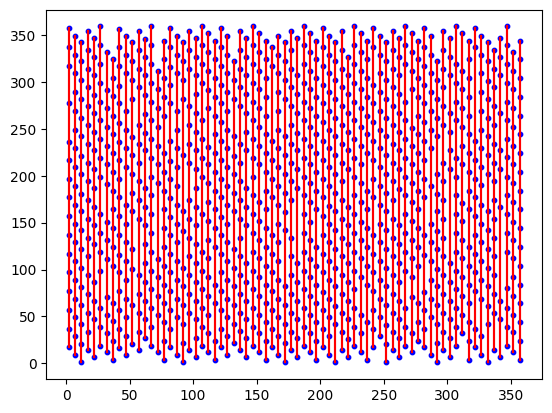

In [15]:
import matplotlib.pyplot as plt
x = [t[0] for t in loc]
y = [t[1] for t in loc]
plt.scatter(x, y, color='blue', s=10)
forward_link = []
for k in sat.keys():
    l = sat[k]
    cur = [item for item in plane_topology if item['sat'] == k][0]
    to_link = [item for item in plane_topology if item['sat'] == l[0]][0]
    forward_link.append([[cur['x'], to_link['x']], [cur['y'], to_link['y']]])
for i in range(len(forward_link)):
    plt.plot(forward_link[i][0], forward_link[i][1], color='red')

plt.show()

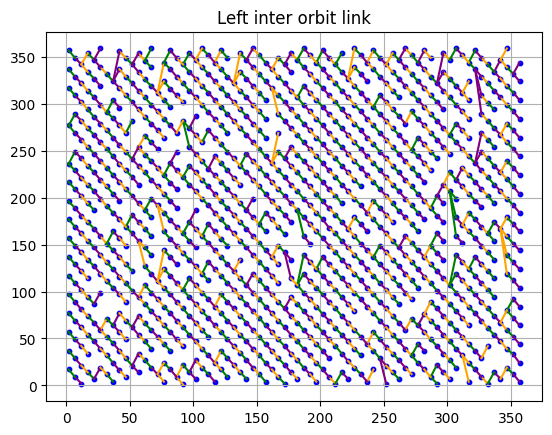

In [16]:
x = [t[0] for t in loc]
y = [t[1] for t in loc]
plt.scatter(x, y, color='blue', s=10)
forward_link = []
for k in sat.keys():
    l = sat[k]
    cur = [item for item in plane_topology if item['sat'] == k][0]
    to_link = [item for item in plane_topology if item['sat'] == l[2]][0]
    forward_link.append([[cur['x'], to_link['x']], [cur['y'], to_link['y']]])
color = ['orange', 'green', 'purple']
for i in range(len(forward_link)):
    if forward_link[i][0][0] == loc_x[0]:
        # Don't plot wrap over
        continue
    color_choice = color[loc_x.index(forward_link[i][0][0]) % len(color)]
    plt.plot(forward_link[i][0], forward_link[i][1], color=color_choice)
plt.title('Left inter orbit link')
plt.grid(True)
plt.show()

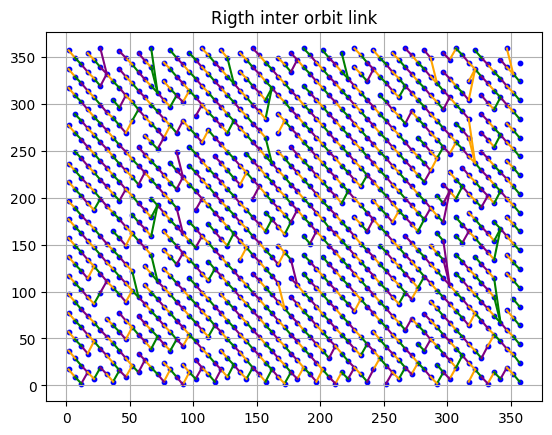

In [17]:
x = [t[0] for t in loc]
y = [t[1] for t in loc]
plt.scatter(x, y, color='blue', s=10)
forward_link = []
for k in sat.keys():
    l = sat[k]
    cur = [item for item in plane_topology if item['sat'] == k][0]
    to_link = [item for item in plane_topology if item['sat'] == l[3]][0]
    forward_link.append([[cur['x'], to_link['x']], [cur['y'], to_link['y']]])
color = ['orange', 'green', 'purple']
for i in range(len(forward_link)):
    if forward_link[i][0][0] == loc_x[-1]:
        # Don't plot wrap over
        continue
    color_choice = color[loc_x.index(forward_link[i][0][0]) % len(color)]
    plt.plot(forward_link[i][0], forward_link[i][1], color=color_choice)
plt.title('Rigth inter orbit link')
plt.grid(True)
plt.show()

In [18]:
sat["2317"]

['1145', '2283', '2393', '2333']

In [19]:
with open('isl.json', 'w') as f:
    json.dump(sat, f, indent=2)

In [29]:
with open('./starlinks_5_2_brief.txt', 'w') as f:
    i = 0
    while i < len(file):
        name = file[i].strip()
        id = file[i].split(' ')[0]
        id = id[id.find('-') + 1:]
        
        if id in sat:
            f.write(file[i])
            f.write(file[i + 1])
            f.write(file[i + 2])
        i += 3